This notebook is based on the ```single_static_target``` example. It is extended to include multiple receiving antennas, which allows to estimate target angles (direction of arrival, DOA).

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import speed_of_light as c0
import skradar

# Scene Setup
See the ```single_static_target``` example for a detailed description of the configuration of radar, target, and scene.

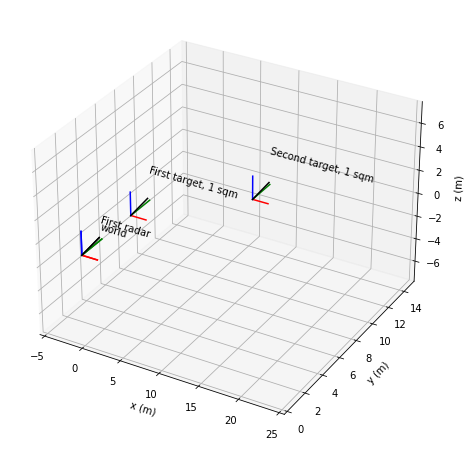

In [7]:
B = 1e9
fc = 76.5e9
N_f = 512  # number of fast-time samples
fs_f = 1e6  # fast-time sampling rate
Ts_s = (N_f-1)/fs_f  # slow-time sampling interval
N_s = 1  # number of slow-time samples

lambd = c0/fc

tx_pos = np.array([[0], [0], [0]])
rx_pos = np.array([
                    [[0], [0], [0]],
                    [[lambd/2], [0], [0]],
                    [[2*lambd/2], [0], [0]],
                    [[3*lambd/2], [0], [0]]
                ])

radar_pos = np.array([[0], [0], [0]])
radar = skradar.FMCWRadar(B=B, fc=fc, N_f=N_f, T_f=1/fs_f, T_s=Ts_s,
                          N_s=N_s, tx_pos=tx_pos, rx_pos=rx_pos,
                          pos=radar_pos, name='First radar')

target_lst = list()
target_lst.append(skradar.Target(rcs=1, pos=np.array([[0], [5], [0]]), name='First target, 1 sqm'))
target_lst.append(skradar.Target(rcs=1, pos=np.array([[10], [10], [0]]), name='Second target, 1 sqm'))

scene = skradar.Scene([radar], target_lst)

fig = plt.figure(1, figsize=(12, 8))
plt.clf()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim((-5, 25))
ax.set_ylim((0, 15))
ax.set_zlim((-7.5, 7.5))
scene.visualize('world', ax, coord_len=2)
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_zlabel('z (m)');

# Radar Signal Simulation and Range Processing
The function ```sim_chirps``` automatically calculates all distances between the targets in the scene and all TX- and RX-antennas. Here ```radar``` is an ```FMCWRadar``` object; therefore the results are the dechirped signals for each TX-RX combination.

In [8]:
radar.sim_chirps()

Now it is possible to perform range compression on the FMCW IF signal which is realized within the ```range_compression``` function.

In [9]:
radar.range_compression(zp_fact=32)

The range profile should show a maximum at the target distance. Real-valued signals lead to a symmetric spectrum, therefore here only half of the range profile is relevant. The values of ```radar.ranges``` describe round-trip ranges. To plot target distances, these values therefore need to be halved (this holds for monostatic radars with TX and RX at the same position).

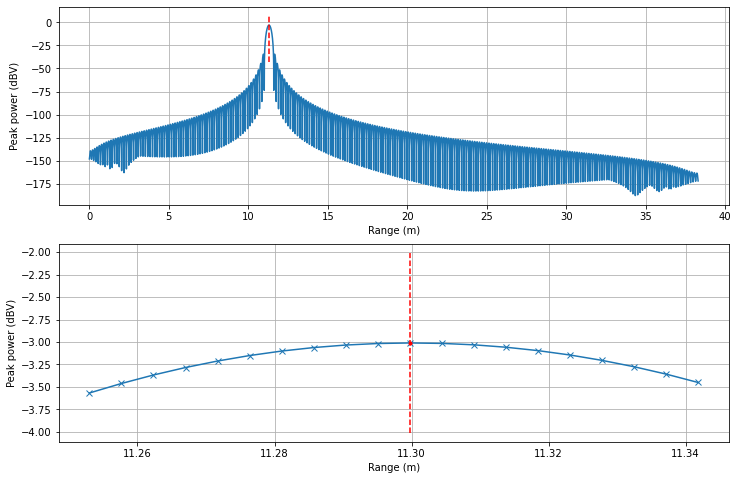

In [14]:
target_dists = radar.ranges/2  # halve values to account for round-trip ranges
target_dists_plot = target_dists[:len(radar.ranges)//2]
# sqrt(2) to convert to RMS power from sinusoidal peak value
rp_plot = 1/(np.sqrt(2))*radar.rp[0, 0, 0, :len(radar.ranges)//2]
peak_idx = np.argmax(np.abs(rp_plot))

plt.figure(2, figsize=(12, 8))
plt.clf()
plt.subplot(2, 1, 1)
plt.plot(target_dists_plot, 20*np.log10(np.abs(rp_plot)))
plt.plot([target_dists_plot[peak_idx], target_dists_plot[peak_idx]], [
         20*np.log10(np.abs(rp_plot[peak_idx]))-40, 20*np.log10(np.abs(rp_plot[peak_idx]))+10], '--r')
plt.grid(True)
plt.xlabel('Range (m)')
plt.ylabel('Peak power (dBV)')
plt.subplot(2, 1, 2)
plt.plot(target_dists_plot[peak_idx-10:peak_idx+10], 20 *
         np.log10(np.abs(rp_plot[peak_idx-10:peak_idx+10])), '-x')
plt.plot(target_dists_plot[peak_idx], 20 *
         np.log10(np.abs(rp_plot[peak_idx])), '.r')
plt.plot([target_dists_plot[peak_idx], target_dists_plot[peak_idx]], [
         20*np.log10(np.abs(rp_plot[peak_idx]))-1, 20*np.log10(np.abs(rp_plot[peak_idx]))+1], '--r')
plt.grid(True)
plt.xlabel('Range (m)')
plt.ylabel('Peak power (dBV)')

In [13]:
print(f'Estimated target distance: {radar.ranges[peak_idx]/2:.3f} m')

Estimated target distance: 11.300 m
